<a href="https://colab.research.google.com/github/itberrios/3D/blob/main/3d_reconstruction/temple_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multiview Stereo Temple Reconstruction**


![img](https://perso.telecom-paristech.fr/boubek/papers/AMR/images/amr_scaled-window-matching.png)

## Main pipeline:
1.   Create the parameters for: **calibration, rectification, disparity estimation**
2.   Create a class that will **collect all parameters**.
3.   Load the **Images**
4.   Test **Rectification, Disparity, and Reprojection**
5.   Putting it **all together**


Download data

In [ ]:
!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/mvs.zip && unzip mvs.zip && rm mvs.zip

In [2]:
!mv mvs/* . && rm -r mvs

In [ ]:
!pip install open3d

In [70]:
import numpy
import pathlib
from pathlib import Path
from time import time
import os
import inspect
import numpy as np
import open3d as o3d
import cv2
import glob
import matplotlib.pyplot as plt

In [4]:
scenario = "temple"

### Display data

Each set of data consists of 12 images that will help us from a 360 degree view of the temple

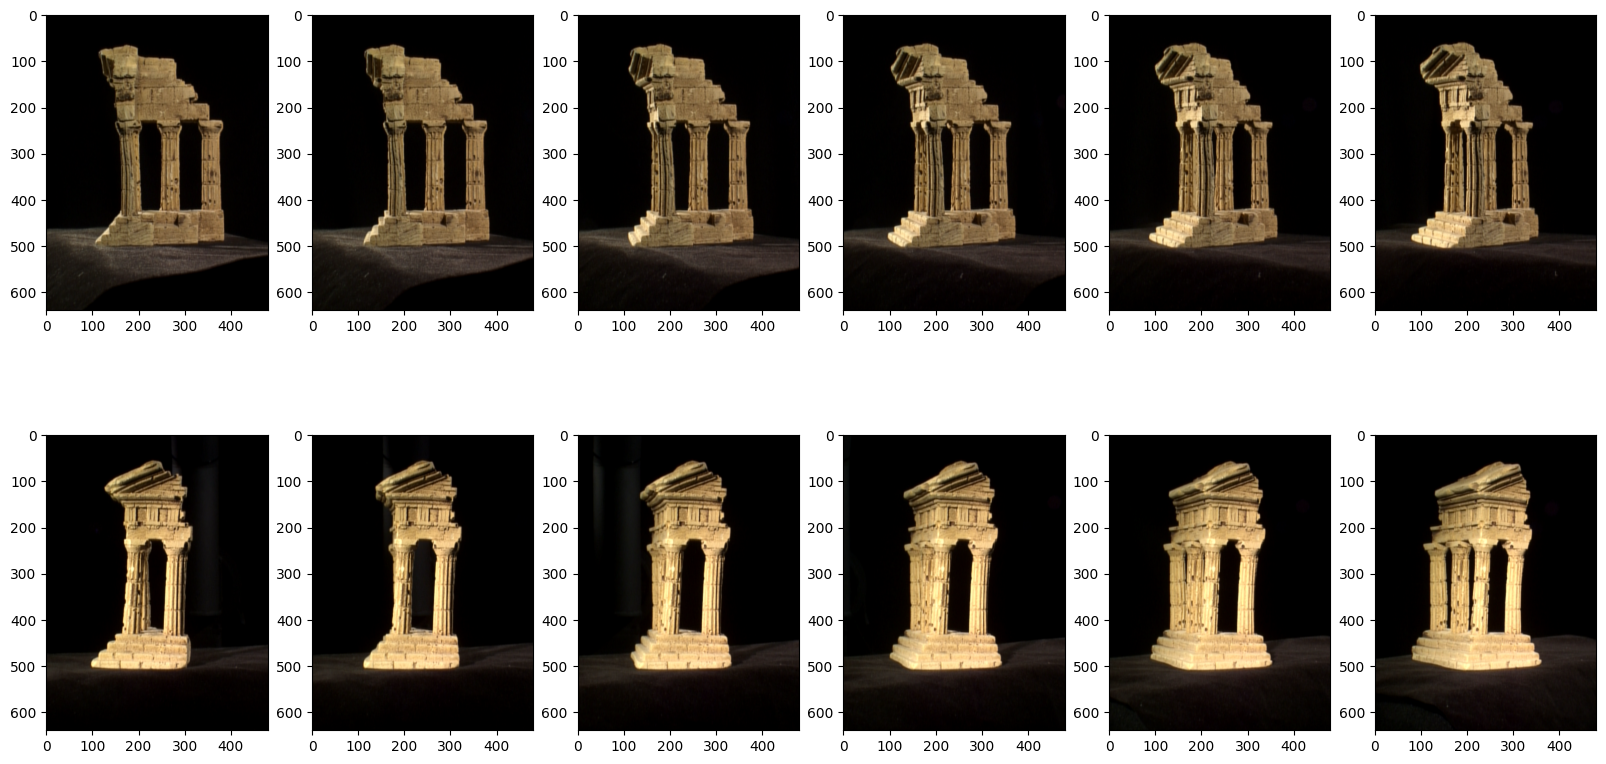

In [11]:
image_path = Path('data/'+scenario+'/undistorted')
images = sorted(glob.glob("data/"+scenario+"/undistorted/*.png"))

images_cv = [cv2.rotate(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), cv2.ROTATE_90_COUNTERCLOCKWISE) for img in images]

f, ((ax0, ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10, ax11)) = plt.subplots(2,6,figsize=(20,10))
ax0.imshow(images_cv[0])
ax1.imshow(images_cv[1])
ax2.imshow(images_cv[2])
ax3.imshow(images_cv[3])
ax4.imshow(images_cv[4])
ax5.imshow(images_cv[5])
ax6.imshow(images_cv[6])
ax7.imshow(images_cv[7])
ax8.imshow(images_cv[8])
ax9.imshow(images_cv[9])
ax10.imshow(images_cv[10])
ax11.imshow(images_cv[11]);

### Topologies
We can organize the images with different topologies in order to change how we reconstruct things

In [10]:
import collections
topologies = collections.OrderedDict()
topologies['360'] = tuple(zip((0,1,2,3,4,5,6,7,8,9,10,11),
                          (1,2,3,4,5,6,7,8,9,10,11,0)))

topologies['overlapping'] = tuple(zip((0,1,2,3,4,5,6,7,8,9,10),
                          (1,2,3,4,5,6,7,8,9,10,11)))

topologies['adjacent'] = tuple(zip((0,2,4,6,8,10),
                     (1,3,5,7,9,11)))
topologies['skipping_1'] = tuple(zip((0,3,6,9),
                 (1,4,7,10)))
topologies['skipping_2'] = tuple(zip((0,4,8),
                 (1,5,9)))

In [17]:
from load_camera_info import load_all_camera_parameters
from load_camera_info_temple import load_all_camera_parameters_temple

all_camera_parameters = load_all_camera_parameters(image_path);
all_camera_parameters_temple = load_all_camera_parameters_temple(image_path);

Loading intrinsics for camera 0 from data/temple/undistorted/intrinsics_camera01.txt ...
Loading extrinsics for camera 0 from data/temple/undistorted/extrinsics_camera01.txt ...
Loading intrinsics for camera 1 from data/temple/undistorted/intrinsics_camera02.txt ...
Loading extrinsics for camera 1 from data/temple/undistorted/extrinsics_camera02.txt ...
Loading intrinsics for camera 2 from data/temple/undistorted/intrinsics_camera03.txt ...
Loading extrinsics for camera 2 from data/temple/undistorted/extrinsics_camera03.txt ...
Loading intrinsics for camera 3 from data/temple/undistorted/intrinsics_camera04.txt ...
Loading extrinsics for camera 3 from data/temple/undistorted/extrinsics_camera04.txt ...
Loading intrinsics for camera 4 from data/temple/undistorted/intrinsics_camera05.txt ...
Loading extrinsics for camera 4 from data/temple/undistorted/extrinsics_camera05.txt ...
Loading intrinsics for camera 5 from data/temple/undistorted/intrinsics_camera06.txt ...
Loading extrinsics fo

In [19]:
all_camera_parameters_temple[0]

{'camera_matrix': array([[1.5204e+03, 0.0000e+00, 3.0230e+02],
        [0.0000e+00, 1.5204e+03, 2.4600e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]),
 'R': array([[ 0.01551372,  0.99884344, -0.04550951],
        [ 0.99922239, -0.0171375 , -0.03550953],
        [-0.03624838, -0.04492323, -0.99833259]]),
 'T': array([[-0.05998548],
        [ 0.00400788],
        [ 0.57088647]]),
 'image_width': 640,
 'image_height': 480,
 'f': 1520.4}

In [20]:
all_camera_parameters[0]

{'camera_matrix': array([[2.85252672e+08, 0.00000000e+00, 3.02000000e+02],
        [0.00000000e+00, 2.85252672e+08, 2.47000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'R': array([[ 0.01551372, -0.0171375 , -0.99833259],
        [ 0.99884344, -0.03550953, -0.05998548],
        [-0.04550951, -0.03624838,  0.00400788]]),
 'T': array([ 0.55366304, -0.96541703,  0.04155768]),
 'image_width': 640,
 'image_height': 480,
 'f': 1520.0,
 'k1': 0.0,
 'k2': 0.0,
 'p1': 0.0,
 'p2': 0.0,
 'k3': 0.0,
 'model': 'halcon_area_scan_polynomial',
 'cx': 302.0,
 'cy': 247.0,
 'pixel_w': 5.32860915073091e-06,
 'pixel_h': 5.32860915073091e-06}

In [38]:
K1, R1, T1, width_1, height_1 = [all_camera_parameters[idx1][key] for key in ('camera_matrix','R','T','image_width','image_height')]
K2, R2, T2, width_2, height_2 = [all_camera_parameters[idx2][key] for key in ('camera_matrix','R','T','image_width','image_height')]

In [24]:
K1, K2

(array([[2.85252672e+08, 0.00000000e+00, 3.02000000e+02],
        [0.00000000e+00, 2.85252672e+08, 2.47000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[2.85252672e+08, 0.00000000e+00, 3.02000000e+02],
        [0.00000000e+00, 2.85252672e+08, 2.47000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

In [28]:
1520, 0.0177071077277789, 1/1520

(1520, 0.0177071077277789, 0.0006578947368421052)

In [31]:
# 0.0177071077277789/5.32860915073091e-06,

In [33]:
def calibrate_and_rectify(left_K, right_K, left_R, right_R, left_T, right_T):
    # Get the parameters
    left_distortion_coefficients = (0.0,0.0,0.0,0.0,0.0)
    right_distortion_coefficients = (0.0,0.0,0.0,0.0,0.0)
    imageSize = (640, 480)
    newImageSize = (640, 480)
    alpha = 0.5

    # Stereo Rectify
    R_intercamera = numpy.dot(right_R, left_R.T) # R * T
    T_intercamera = right_T - numpy.dot(R_intercamera, left_T) # translation and rotation keeping the first one as baseline

    left_R_rectified, right_R_rectified, P1_rect, P2_rect, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(
        cameraMatrix1 = left_K,
        distCoeffs1 = left_distortion_coefficients,
        cameraMatrix2 = right_K,
        distCoeffs2 = right_distortion_coefficients,
        imageSize=imageSize,
        newImageSize=newImageSize,
        R=R_intercamera, T=T_intercamera,
        flags=0,
        alpha=alpha)

    # Back to Global
    R2,T2 = left_R, left_T # perspective is from left image.
    R3,T3 = R2.T,numpy.dot(-R2.T,T2) # Invert direction of transformation to map camera to world.
    R_left_rectified_to_global = numpy.dot(R3,left_R_rectified.T)
    T_left_rectified_to_global = T3
    extrinsics_left_rectified_to_global = R_left_rectified_to_global.astype(numpy.float32), T_left_rectified_to_global.astype(numpy.float32)

    # Create rectification maps
    rectification_map_type = cv2.CV_16SC2
    left_maps = cv2.initUndistortRectifyMap(left_K,
                                            left_distortion_coefficients,
                                            left_R_rectified,
                                            P1_rect,
                                            size=newImageSize,
                                            m1type=rectification_map_type)

    right_maps = cv2.initUndistortRectifyMap(right_K,
                                            right_distortion_coefficients,
                                            right_R_rectified,
                                            P2_rect,
                                            size=newImageSize,
                                            m1type=rectification_map_type)

    return Q, extrinsics_left_rectified_to_global, left_maps, right_maps

In [51]:
def get_disparity_temple(options):
    minDisparity = options['StereoMatcher']['MinDisparity']
    numDisparities = options['StereoMatcher']['NumDisparities']
    blockSize = options['StereoMatcher']['BlockSize']
    P1 = options['StereoSGBM']['P1']
    P2 = options['StereoSGBM']['P2']
    Disp12MaxDiff = options['StereoMatcher']['Disp12MaxDiff']
    uniquenessRatio = options['StereoSGBM']['UniquenessRatio']
    speckleWindowSize = options['StereoMatcher']['SpeckleWindowSize']
    speckleRange = options['StereoMatcher']['SpeckleRange']
    PreFilterCap = options['StereoSGBM']['PreFilterCap']

    matcher = cv2.StereoSGBM_create(
                                    minDisparity=minDisparity,
                                    numDisparities=numDisparities,
                                    blockSize=blockSize,
                                    P1=P1,
                                    P2=P2,
                                    disp12MaxDiff = Disp12MaxDiff,
                                    preFilterCap =PreFilterCap,
                                    uniquenessRatio=uniquenessRatio,
                                    speckleWindowSize=speckleWindowSize,
                                    speckleRange=speckleRange)
    setterOptions = {}
    setterOptions.update(options['StereoMatcher'])
    setterOptions.update(options['StereoSGBM'])

    #setterOptions.update(options['StereoSGBM'])
    for key,value in setterOptions.items():
        setter = eval('matcher.set'+key) # Returns the setter function
        setter(value) # Calls the setter function.

    return matcher


def get_disparity_temple_filter(rimg1, rimg2):
    maxd = 2
    window_size = 5
    left_matcher = cv2.StereoSGBM_create(minDisparity=-maxd, numDisparities=11,
        blockSize=5,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=0,
        speckleRange=2,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    lmbda = 8000
    sigma = 1.5
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    displ = left_matcher.compute(rimg1, rimg2)
    dispr = right_matcher.compute(rimg2, rimg1)
    displ = numpy.int16(displ)
    dispr = numpy.int16(dispr)
    disparity = wls_filter.filter(displ, rimg1, None, dispr) / 16.0
    return disparity

In [45]:
def load_image(img_path):
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    return image

In [53]:
w, h = 640, 480

StereoMatcherTemple = {
                        'MinDisparity': 0,
                        'NumDisparities': 64,
                        'BlockSize': 7,
                        'Disp12MaxDiff': 0,
                        'PreFilterCap' : 0,
                        'UniquenessRatio' : 15,
                        'SpeckleWindowSize' : 50,
                        'SpeckleRange' : 1
                     }

StereoSGBMTemple = {
    'PreFilterCap': 0,
    'UniquenessRatio': 0,
    'P1': 8, # "Depth Change Cost in Ensenso terminology"
    'P2': 32, # "Depth Step Cost in Ensenso terminology"
    }

StereoRectifyOptions = {'imageSize': (w,h), # (h,w), # (w,h),
                        'flags':(0, cv2.CALIB_ZERO_DISPARITY)[1], # TODO explore other flags
                        'newImageSize': (w,h), # (h,w),# (w,h),
                        'alpha':0.5}

RemapOptions = {'interpolation':cv2.INTER_LINEAR}

CameraArrayOptions = {'channels':1,'num_cameras':12,'topology':'overlapping'} #topology=skipping_1, skipping_2, adjacent, overlapping, 360

TempleOptions = {'StereoRectify':StereoRectifyOptions,
        'StereoMatcher':StereoMatcherTemple,
        'StereoSGBM':StereoSGBMTemple,#change to "StereoSGBM" = StereoSGBMOptions if needed
        }

In [46]:
idx1 = 0
idx2 = 1

img0 = load_image(images[idx1])
img1 = load_image(images[idx2])

K1, R1, T1, width_1, height_1 = [all_camera_parameters_temple[idx1][key] for key in ('camera_matrix','R','T','image_width','image_height')]
K2, R2, T2, width_2, height_2 = [all_camera_parameters_temple[idx2][key] for key in ('camera_matrix','R','T','image_width','image_height')]

Q, extrinsics_left_rectified_to_global, left_maps, right_maps = calibrate_and_rectify(K1, K2, R1, R2, T1, T2)

left_image_rectified = cv2.remap(img0, left_maps[0], left_maps[1], cv2.INTER_LINEAR)
right_image_rectified = cv2.remap(img1, right_maps[0], right_maps[1], cv2.INTER_LINEAR)

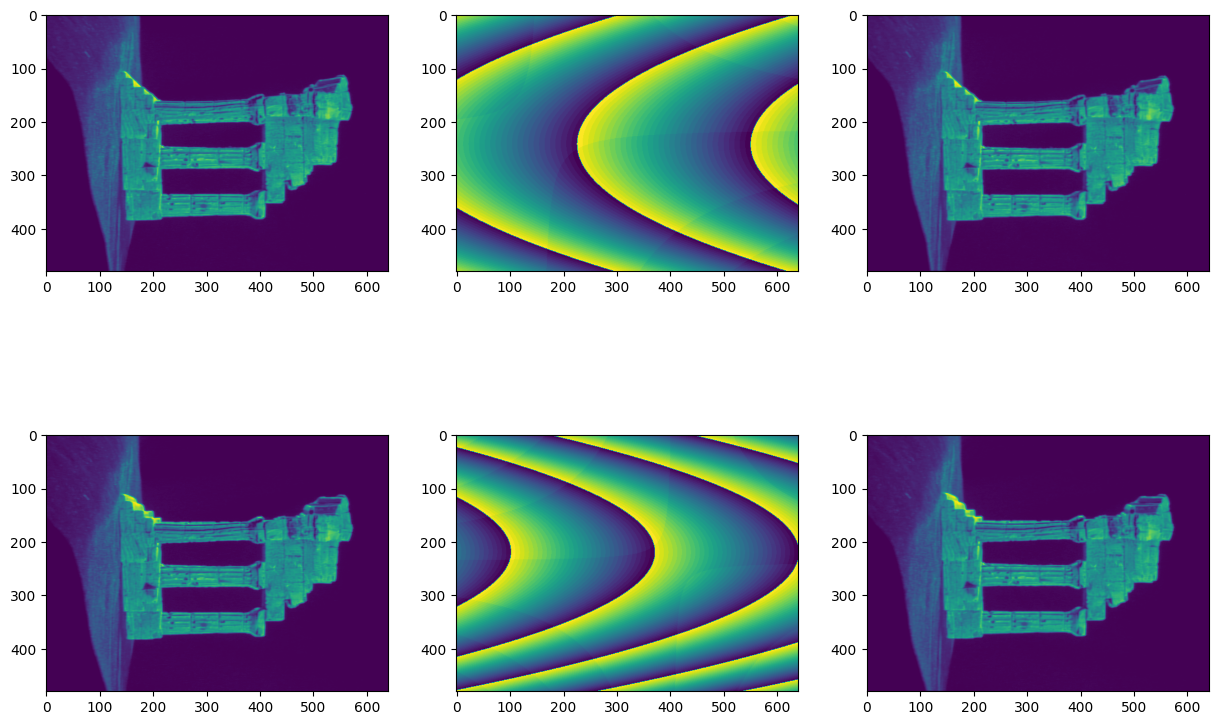

In [58]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].imshow(img0)
ax[0, 1].imshow(left_maps[1])
ax[0, 2].imshow(left_image_rectified)

ax[1, 0].imshow(img1)
ax[1, 1].imshow(right_maps[1])
ax[1, 2].imshow(right_image_rectified)

## Compute Filtered disparity

In [61]:
disparity_img = get_disparity_temple_filter(left_image_rectified, right_image_rectified)

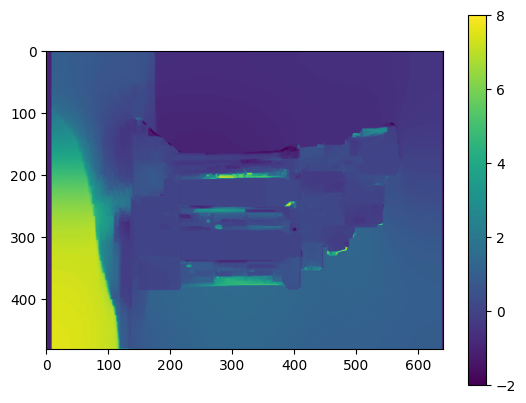

In [63]:
plt.imshow(disparity_img)
plt.colorbar();

In [373]:
threedeeimage = numpy.array(cv2.reprojectImageTo3D(disparity_img.astype(np.float32), Q, handleMissingValues=True, ddepth=cv2.CV_32FC1))

In [292]:
normed_depth = cv2.normalize(threedeeimage[:, :, 2], dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

In [117]:
depth = threedeeimage[:, :, 2]
flat_depth = depth.flatten()

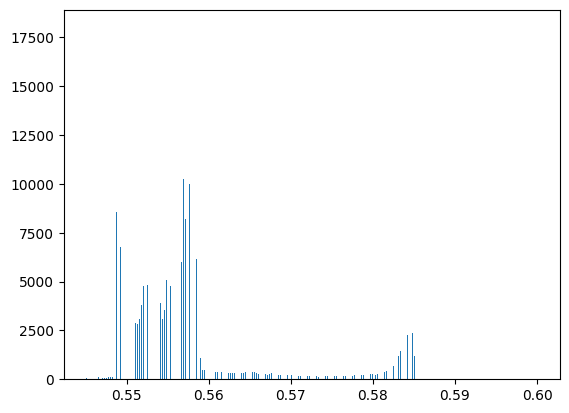

In [334]:
plt.hist(flat_depth[flat_depth < 1], bins=1000);

In [110]:
np.sum(depth > 0.6)

76

In [111]:
depth[depth >= 0.6] = 0.6

In [331]:
depth.min(), depth.max()

(0.54507136, 0.6)

In [335]:
cnts, bins = np.histogram(depth.flatten(), bins=1000)

In [336]:
# cnts, bins

In [353]:
mask = np.zeros_like(depth).astype(bool)
for i in range(len(cnts) - 1):
  c, b = cnts[i], bins[i]
  if (c >= 7000):
     mask = np.logical_or(mask, (depth > b) & (depth < bins[i + 1]))


In [354]:
b, bins[i + 1], i

(0.5998902, 0.59994507, 998)

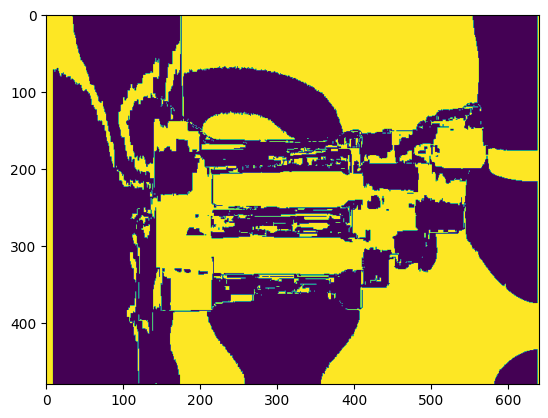

In [355]:
plt.imshow(mask)

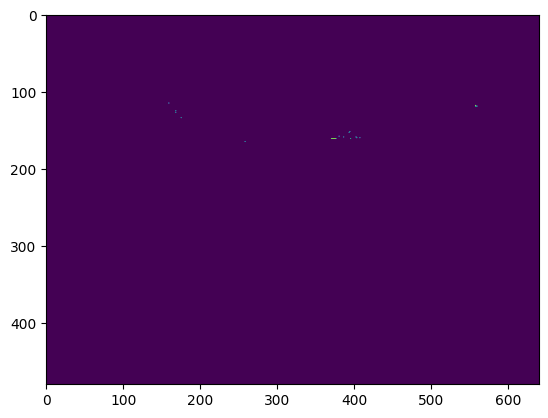

In [349]:
plt.imshow((depth > bins[8]) & (depth < bins[9]))

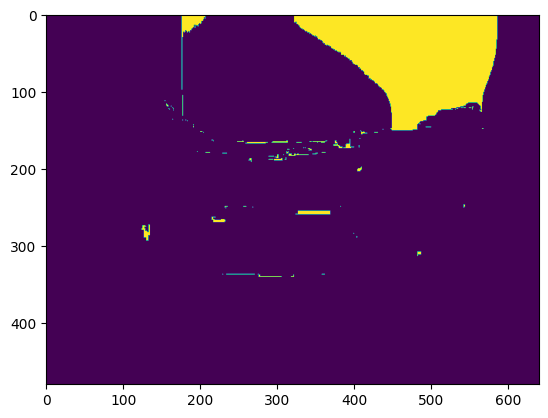

In [309]:
plt.imshow((depth > bins[9]) & (depth < bins[10]))

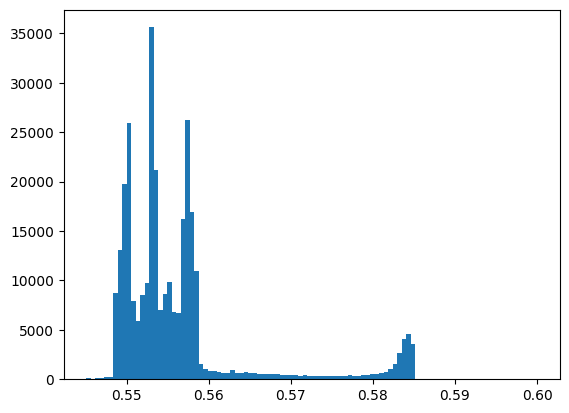

In [127]:
plt.hist(depth.flatten(), bins=100);

(0.54, 0.56)

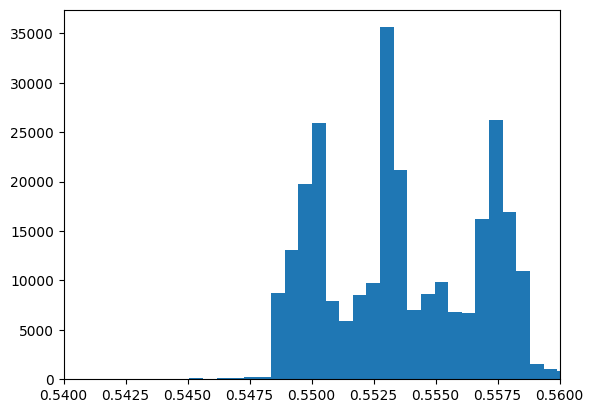

In [281]:
plt.hist(depth.flatten(), bins=100);
plt.xlim(0.54, 0.56)

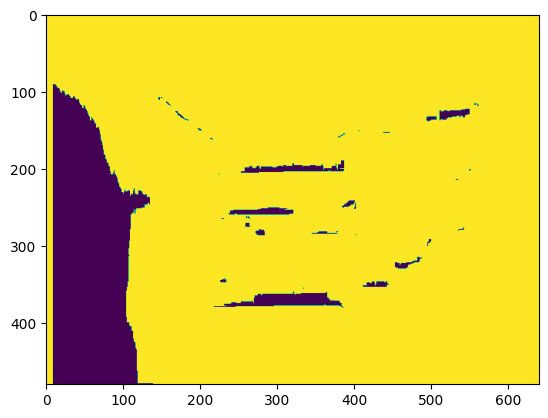

In [282]:
plt.imshow((depth > 0.54) & (depth < 0.56));

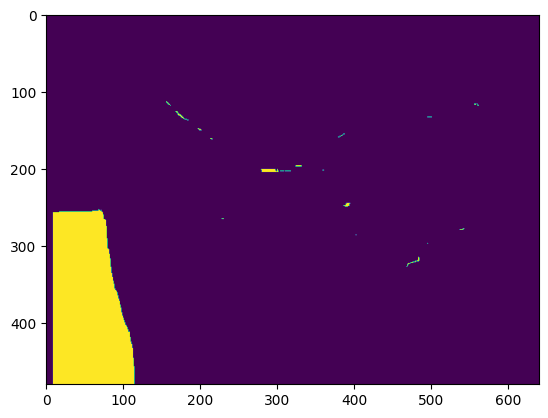

In [279]:
plt.imshow((depth > 0.58))

In [371]:
depth.min(), depth.max()

(0.54507136, 0.6)

In [383]:
threedeeimage[:, :,  2].min()

0.54507136

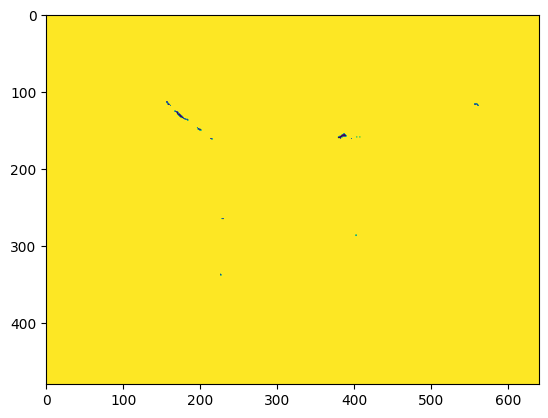

In [384]:
plt.imshow((threedeeimage[:, :,  2] < 1) & (threedeeimage[:, :,  2] > threedeeimage[:, :,  2].min()));

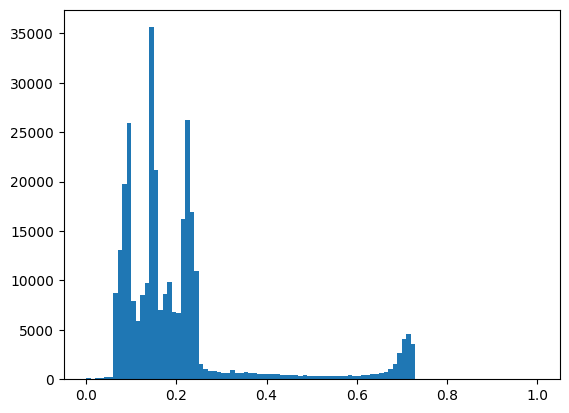

In [293]:
plt.hist(normed_depth.flatten(), bins=100);

In [294]:
normed_depth.min(), normed_depth.max()

(3.9343195e-07, 1.0000005)

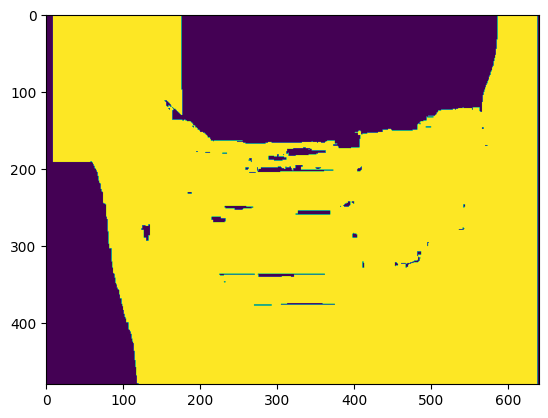

In [298]:
plt.imshow((normed_depth > 0.1) & (normed_depth < 0.5));

Process as 3D point cloud

In [136]:
from load_ply import save_ply


xyz = threedeeimage.reshape((-1,3)) # x,y,z now in three columns, in left rectified camera coordinates
z = xyz[:,2]
goodz = z < 9999.0
xyz_filtered = xyz[goodz,:]

# Global Coordinates
R_left_rectified_to_global, T_left_rectified_to_global = extrinsics_left_rectified_to_global
xyz_global_ = numpy.dot(xyz_filtered, R_left_rectified_to_global.T) + T_left_rectified_to_global.T

# Save PLY
save_ply(xyz_global_, 'pair_test_0_1.ply')

# Make pipeline and run on all images

In [360]:

def pipeline(topology=topologies['adjacent']):

    xyz_global_array = [None]*len(topology)
    xyz_dict = {}

    for pair_idx, (idx1, idx2) in enumerate(topology):

        # 1) load images
        img0 = load_image(images[idx1])
        img1 = load_image(images[idx2])

        # 2) get camera parameters
        K1, R1, T1, width_1, height_1 = [all_camera_parameters_temple[idx1][key] for key in ('camera_matrix','R','T','image_width','image_height')]
        K2, R2, T2, width_2, height_2 = [all_camera_parameters_temple[idx2][key] for key in ('camera_matrix','R','T','image_width','image_height')]

        # 3) calibrate and rectify
        Q, extrinsics_left_rectified_to_global, left_maps, right_maps = calibrate_and_rectify(K1, K2, R1, R2, T1, T2)

        left_image_rectified = cv2.remap(img0, left_maps[0], left_maps[1], cv2.INTER_LINEAR)
        right_image_rectified = cv2.remap(img1, right_maps[0], right_maps[1], cv2.INTER_LINEAR)

        # 4) compute filtered disparity
        disparity = get_disparity_temple_filter(left_image_rectified, right_image_rectified)
        print(disparity.min(), disparity.max())

        # 5) reproject 3D
        threedeeimage = np.array(cv2.reprojectImageTo3D(disparity.astype(np.float32), Q, handleMissingValues=True, ddepth=cv2.CV_32F))
        print(threedeeimage[:, :, 2].min(), threedeeimage[:, :, 2].max())
        print()

        # 6) postprocess into point cloud
        xyz = threedeeimage.reshape((-1,3)) # x,y,z now in three columns, in left rectified camera coordinates
        z = xyz[:,2]
        goodz = z < 1 # 9999.0
        xyz_filtered = xyz[goodz,:]

        # 7) obtain global Coordinates
        R_left_rectified_to_global, T_left_rectified_to_global = extrinsics_left_rectified_to_global
        xyz = numpy.dot(xyz_filtered, R_left_rectified_to_global.T) + T_left_rectified_to_global.T

        # add point cloud to dictionary
        xyz_dict.update({f"{pair_idx}" : xyz})

        # save PLY
        save_ply(xyz, 'pair_'+str(idx1)+'_'+str(idx2)+'.ply')
        xyz_global_array[pair_idx] = xyz

    xyz_global = numpy.vstack(xyz_global_array)

    return xyz_dict, xyz_global

In [361]:
xyz_dict, xyz_global = pipeline(topology=topologies['adjacent'])

-2.0 8.0
0.54507136 10000.0

-2.0 8.0
0.5456463 10000.0

-2.0 8.0
0.5456463 10000.0

-2.0 8.0
0.5456463 10000.0

-2.0 7.9375
0.5456463 10000.0

-2.0 8.0
0.54564637 10000.0



In [362]:
xyz_dict.keys()

dict_keys(['0', '1', '2', '3', '4', '5'])

In [363]:
save_ply(xyz_global, "temple.ply")

## Remove image planes

We will have image plane artifacts in the point cloud that need to be removed. The number of image planes will be equal to the total number of image pairs that we processed.

In [158]:
num_planes = len(topologies['adjacent'])
num_planes

6

In [149]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

In [152]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)

In [153]:
plane_model

array([0.91125486, 0.01969345, 0.41137179, 0.0236061 ])

## New method

1. First, register each pair of point clouds


ref: http://www.open3d.org/docs/release/tutorial/pipelines/global_registration.html

In [173]:
def preprocess_point_cloud(xyz, voxel_size):

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)

    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [187]:
pcd_down_1, pcd_fpfh_1 = preprocess_point_cloud(xyz=xyz_dict['0'], voxel_size=0.001)
pcd_down_2, pcd_fpfh_2 = preprocess_point_cloud(xyz=xyz_dict['1'], voxel_size=0.001)

:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.


In [206]:
xyz_dict['0'].shape, xyz_dict['1'].shape

((307124, 3), (306856, 3))

In [189]:
pcd_down_1, pcd_down_2

(PointCloud with 52277 points., PointCloud with 53242 points.)

In [191]:
result = execute_global_registration(pcd_down_1, pcd_down_2, pcd_fpfh_1, pcd_fpfh_2, voxel_size=0.001)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.001,
   we use a liberal distance threshold 0.002.


In [192]:
result

RegistrationResult with fitness=2.839681e-01, inlier_rmse=8.633647e-04, and correspondence_set size of 14845
Access transformation to get result.

In [ ]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

In [194]:
pcd_down_2.transform(result.transformation)

PointCloud with 53242 points.

In [202]:
combined_pcds = pcd_down_1 + pcd_down_2.transform(result.transformation)

In [203]:
combined_pcds

PointCloud with 105519 points.

In [204]:
o3d.io.write_point_cloud('registered_0_1.ply', combined_pcds, write_ascii=False)

True

## Another new method - Remove the plane from each reconstructed point cloud

In [385]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_dict['0'])

# downsample
pcd = pcd.voxel_down_sample(voxel_size=0.001)

# use ransac to remove entire plane
plane_model, inliers = pcd.segment_plane(distance_threshold=0.0005,
                                         ransac_n=3,
                                         num_iterations=1000)

inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)

o3d.io.write_point_cloud('pair_0_1_inliers.ply', inlier_cloud, write_ascii=False)
o3d.io.write_point_cloud('pair_0_1_outliers.ply', outlier_cloud, write_ascii=False)


True

In [386]:
pcd, inlier_cloud, outlier_cloud

(PointCloud with 52277 points.,
 PointCloud with 11147 points.,
 PointCloud with 41130 points.)

In [265]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=0.01, min_points=100, print_progress=True))

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2


In [269]:
np.unique(labels)

array([-1,  0,  1], dtype=int32)

In [268]:
max_label = np.max(labels)
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       ...,
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.12156863, 0.46666667, 0.70588235, 1.        ]])

In [275]:
clusters = []
for lbl in np.unique(labels):
    clusters.append(pcd.select_by_index(np.where(labels == lbl)[0]))

In [276]:
clusters

[PointCloud with 534 points.,
 PointCloud with 51643 points.,
 PointCloud with 100 points.]

ref: http://www.open3d.org/docs/release/tutorial/geometry/pointcloud_outlier_removal.html

In [245]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(xyz_dict['0'])

# # downsample
# pcd = pcd.voxel_down_sample(voxel_size=0.001)

# # remove statistica outliers
# # cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.05)

# # radius outlier removal
# cl, ind = pcd.remove_radius_outlier(nb_points=100, radius=0.075)

# inlier_cloud = pcd.select_by_index(ind)
# outlier_cloud = pcd.select_by_index(ind, invert=True)

# o3d.io.write_point_cloud('pair_0_1_inliers.ply', inlier_cloud, write_ascii=False)
# o3d.io.write_point_cloud('pair_0_1_outliers.ply', outlier_cloud, write_ascii=False)

KeyboardInterrupt: ignored

In [ ]:
# pcd, cl

In [234]:
plane_model

array([ 0.04795927,  0.03019915,  0.99839267, -0.0149846 ])